In [1]:
# Gibeom Lee, HI Lab
# 이 코드는 AC의 frequency 를 측정해주는 코드입니다.
# 만약 TENG ac 전압이라면, 피크를 +/-값 모두 잡아 2배의 frequency가 나올 가능성이 있습니다.

In [2]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

샘플링 속도: 250.02 Hz
추정 주기당 샘플 수: 7
평균 주파수: 5.74 Hz
최종 피크 개수: 229
최종 height 기준: 30
최종 prominence 기준: 5.731


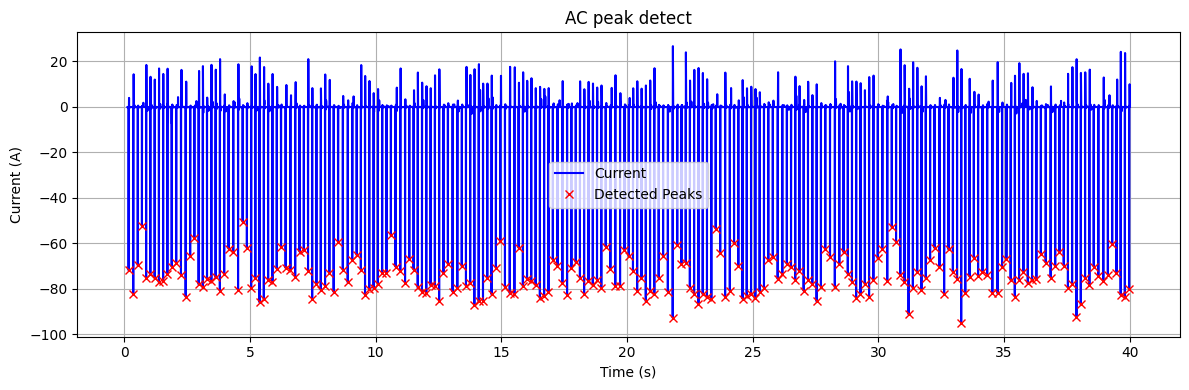

In [16]:
# -------------------------------
# 파일 로드 및 기본 정보
file_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\3. Material selection\250729_UC1모양으로 코팅별\10k_csv\freq 측정\Frequency_16mLmin.csv"

# CSV 파일 읽기 (30줄 스킵, 열 이름 지정)
df = pd.read_csv(file_path, header=None, names=["Time", "Current"], skiprows=30)

# NumPy 배열로 변환
time = df["Time"].values
current = df["Current"].values

# 샘플링 속도 계산
total_time = time[-1] - time[0]
sampling_rate = len(time) / total_time
print(f"샘플링 속도: {sampling_rate:.2f} Hz")

# -------------------------------
# 1차 피크 탐지: 민감도 높게 대략 찾기
mean_current = np.mean(current)
std_current = np.std(current)

rough_height = mean_current + 0.1 * std_current  # 약한 피크도 탐지
rough_distance = int(sampling_rate * 0.05)      # 최소 간격 0.005초

# 양/음 피크 탐지
p_peaks_rough, _ = find_peaks(current, height=rough_height, distance=rough_distance)
n_peaks_rough, _ = find_peaks(-current, height=rough_height, distance=rough_distance)

# 피크 시간 추출
rough_peaks = np.sort(np.concatenate([p_peaks_rough, n_peaks_rough]))
rough_peak_times = time[rough_peaks]

# 주기 및 샘플 길이 추정
if len(rough_peak_times) < 2:
    raise ValueError("피크가 너무 적어 주기 추정 불가")

estimated_period = np.median(np.diff(rough_peak_times))
estimated_samples_per_cycle = int(estimated_period * sampling_rate)
print(f"추정 주기당 샘플 수: {estimated_samples_per_cycle}")

# -------------------------------
# 2차 피크 탐지: 조건 강화
final_height = 30  # 최소 피크 전류 직접 지정 (필요 시 수정)
final_prominence = 0.5 * std_current

p_peaks_final, _ = find_peaks(
    current,
    height=final_height,
    distance=int(0.8 * estimated_samples_per_cycle),
    prominence=final_prominence
)
n_peaks_final, _ = find_peaks(
    -current,
    height=final_height,
    distance=int(0.8 * estimated_samples_per_cycle),
    prominence=final_prominence
)

# 최종 피크 결합
final_peaks = np.sort(np.concatenate([p_peaks_final, n_peaks_final]))
final_peak_times = time[final_peaks]

# -------------------------------
# 주기, 주파수 계산
if len(final_peak_times) < 2:
    mean_frequency = 0
    print("⚠ 최종 피크가 너무 적습니다. 주파수 계산 불가.")
else:
    periods = np.diff(final_peak_times)
    frequencies = 1 / periods
    mean_frequency = np.mean(frequencies)

    print(f"평균 주파수: {mean_frequency:.2f} Hz")
    #print(f"간단 주파수: {len(final_peaks)/np.sum(periods):.2f} Hz-노이즈 많을 때 참고")

print(f"최종 피크 개수: {len(final_peaks)}")
print(f"최종 height 기준: {final_height}")
print(f"최종 prominence 기준: {final_prominence:.3f}")

# -------------------------------
# 시각화
plt.figure(figsize=(12, 4))
plt.plot(time, current, label='Current', color='blue')
plt.plot(final_peak_times, current[final_peaks], 'rx', label='Detected Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("AC peak detect")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
